In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d odins0n/ucf-crime-dataset

100% 11.0G/11.0G [01:36<00:00, 116MB/s]
100% 11.0G/11.0G [01:36<00:00, 123MB/s]


In [ ]:
!unzip /content/ucf-crime-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Train/Vandalism/Vandalism035_x264_230.png  
  inflating: Train/Vandalism/Vandalism035_x264_240.png  
  inflating: Train/Vandalism/Vandalism035_x264_250.png  
  inflating: Train/Vandalism/Vandalism035_x264_260.png  
  inflating: Train/Vandalism/Vandalism035_x264_270.png  
  inflating: Train/Vandalism/Vandalism035_x264_280.png  
  inflating: Train/Vandalism/Vandalism035_x264_290.png  
  inflating: Train/Vandalism/Vandalism035_x264_30.png  
  inflating: Train/Vandalism/Vandalism035_x264_300.png  
  inflating: Train/Vandalism/Vandalism035_x264_310.png  
  inflating: Train/Vandalism/Vandalism035_x264_320.png  
  inflating: Train/Vandalism/Vandalism035_x264_330.png  
  inflating: Train/Vandalism/Vandalism035_x264_340.png  
  inflating: Train/Vandalism/Vandalism035_x264_350.png  
  inflating: Train/Vandalism/Vandalism035_x264_360.png  
  inflating: Train/Vandalism/Vandalism035_x264_370.png  
  inflating: Train/Vandalism/Vandalism

In [ ]:
train_dir = '/content/Train'
test_dir = '/content/Test'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D, Conv2D,Flatten
from tensorflow.keras.models import Sequential

from IPython.display import clear_output
import warnings 

warnings.filterwarnings('ignore')


In [ ]:
train_dir = '/content/Train'
test_dir = '/content/Test'

SEED = 1
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 1024
EPOCHS = 5
LR = 0.00003

In [ ]:
crime_types = os.listdir(train_dir)
n = len(crime_types)
print("Number of crime categories : ",n)

Number of crime categories :  14


In [ ]:
crimes = {}
train = test = 0
for clss in crime_types:
  num = len(os.listdir(os.path.join(train_dir,clss)))
  train+=num
  test+=len(os.listdir(os.path.join(test_dir,clss)))
  crimes[clss] = num


Text(0.5, 1.0, 'Train and Test Images')

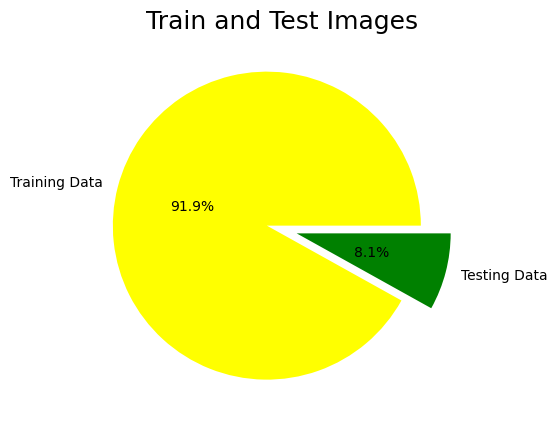

In [ ]:
plt.figure(figsize=(8,5))
plt.pie(x = np.array([train,test]), autopct="%.1f%%",explode=[0.1,0.1],labels=["Training Data", "Testing Data"], pctdistance = 0.5, colors =['yellow','green'])
plt.title("Train and Test Images",fontsize = 18)

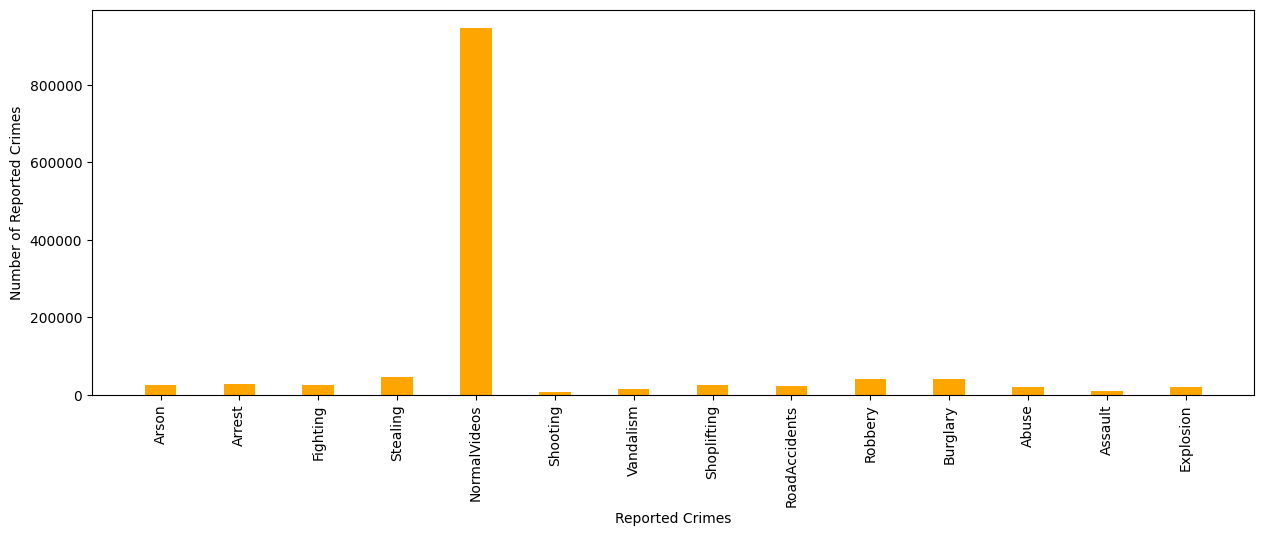

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(list(crimes.keys()), list(crimes.values()),width = 0.4, align ='center',color =['orange'])
plt.xticks(rotation = 90)

plt.xlabel("Reported Crimes")
plt.ylabel("Number of Reported Crimes")
plt.show()

In [ ]:
train_set = image_dataset_from_directory(
    train_dir,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    image_size = (64,64),
    shuffle = True,
    seed = SEED,
    validation_split = 0.2,
    subset = 'training'
)

Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.


In [ ]:
val_set = image_dataset_from_directory(
    train_dir,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    image_size = (64,64),
    shuffle = True,
    seed = SEED,
    validation_split =0.2,
    subset = 'validation',
)

Found 1266345 files belonging to 14 classes.
Using 253269 files for validation.


In [ ]:
test_set = image_dataset_from_directory(
    test_dir,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    image_size = (64,64),
    shuffle = False,
    seed = SEED,
)

Found 111308 files belonging to 14 classes.


Transfer Learning

In [ ]:
def transfer_learning():
  base_model = DenseNet121(include_top = False, input_shape = (64,64,3), weights = 'imagenet')

  thr = 149
  for layers in base_model.layers[:thr]:
    layers.trainable = False

  for layers in base_model.layers[thr:]:
    layers.trainable = False

  return base_model

In [ ]:
def create_model():
  model = Sequential()

  base_model = transfer_learning()
  model.add(base_model)

  model.add(GlobalAveragePooling2D())

  
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(0.2))

  model.add(Dense(512, activation = 'relu'))
  model.add(Dropout(0.2))

  model.add(Dense(1024, activation ='relu'))

  model.add(Dense(n, activation='softmax'))

  model.summary()

  return model

In [ ]:
model = create_model()
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0 

In [ ]:
history = model.fit(x = train_set,validation_data=val_set, epochs = 1)

990/990 [==============================] - 19533s 20s/step - loss: 0.4804 - accuracy: 0.8869 - val_loss: 0.1131 - val_accuracy: 0.9708


In [ ]:
model.save('crime.h5')

Testing the model


In [ ]:
from tensorflow.keras.models import load_model
model.load_weights('crime.h5')

In [ ]:
y_true = np.array([])

for x, y in test_set:
  y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis = -1)])

In [ ]:
y_pred = model.predict(test_set)

109/109 [==============================] - 1670s 15s/step


In [ ]:
y_pred

array([[2.40651995e-01, 1.98127925e-02, 1.56086795e-02, ...,
        1.21489717e-02, 1.79330315e-02, 5.72354533e-02],
       [1.95086598e-01, 2.83409357e-02, 1.48281604e-02, ...,
        2.91524287e-02, 6.10545697e-03, 7.50974938e-02],
       [4.62537073e-02, 8.71622041e-02, 2.72435253e-03, ...,
        1.50310192e-02, 8.44376773e-05, 1.10284187e-01],
       ...,
       [1.38990799e-06, 9.76940064e-05, 3.56464661e-05, ...,
        1.91383049e-04, 1.24437904e-07, 3.31283104e-06],
       [2.86542445e-07, 1.30147801e-05, 1.97303302e-06, ...,
        2.57729753e-05, 4.76597926e-08, 7.61821866e-07],
       [2.21753471e-05, 4.55239293e-04, 1.84207325e-04, ...,
        4.86470410e-04, 2.87774100e-07, 7.50982963e-06]], dtype=float32)

In [ ]:
y_true

In [31]:
from tensorflow.keras.preprocessing import image

In [32]:
img = image.load_img('/content/Test/Assault/Assault006_x264_100.png')
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
pred = np.argmax(model.predict(x))
op = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting','NormalVideos','RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']
op[pred]

1/1 [==============================] - 3s 3s/step


'NormalVideos'

In [34]:
img = image.load_img('/content/Test/Assault/Assault006_x264_100.png')
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
pred = np.argmax(model.predict(x))
op = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting','NormalVideos','RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']
op[pred]

1/1 [==============================] - 0s 71ms/step


'RoadAccidents'

In [36]:
img = image.load_img('/content/Test/NormalVideos/Normal_Videos_003_x264_0.png')
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
pred = np.argmax(model.predict(x))
op = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting','NormalVideos','RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']
op[pred]

1/1 [==============================] - 0s 79ms/step


'NormalVideos'